# Init

In [13]:

import os
import pickle
import pandas as pd
# from postProcessingFunctions import processOutputs, replaceValueInFile, parallelizeFunction, genExtList
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import gumbel_r, gumbel_l
from scipy.stats import genextreme

import re

import numpy as np

from IPython.display import display, Markdown

import moorpy as mp
import copy

# from moorpy_functions import genMoorpySys2


In [14]:
resultsFol = r'..'
dataFol = r'..\..\data'

In [15]:

fatBinDf = pd.read_excel(os.path.join(dataFol, r"envCond.xlsx"), sheet_name='9.6D_deficit', skiprows=[1])
# df['bin'] = df['index'].str.extract(r'_.*_(\d+)_.').astype(int)
# df = df.sort_values(by='bin')
# df = df.merge(fatBinDf, on='bin', how='left')


#checked the impact of reducing the chain size directly - without actually adjusting the chain properties
lineDamageDict  = {     
                  #     'C135_0'   : os.path.join(r"P200_C135_L1430_clump40_fat_0_damage.parquet"),
                      'C135_10'  : os.path.join(r"P200_C135_L1430_clump40_fat_10_damage.parquet"),
                      'C135_-50' : os.path.join(r"P200_C135_L1430_clump40_fat_-50_damage.parquet"),
                      
                }


In [16]:
LineMap = { 'ANCHTEN1' : 'Line 1 : Btm Chain - Btm',
            'FAIRTEN1' : 'Line 1 : Btm Chain - Top',
            'ANCHTEN6' : 'Line 1 : Top Chain - Btm',
            'FAIRTEN6' : 'Line 1 : Top Chain - Top',

            'ANCHTEN7' : 'Line 2 : Btm Chain - Btm',
            'FAIRTEN7' : 'Line 2 : Btm Chain - Top',
            'ANCHTEN12' : 'Line 2 : Top Chain - Btm',
            'FAIRTEN12' : 'Line 2 : Top Chain - Top',

            'ANCHTEN13' : 'Line 3 : Btm Chain - Btm',
            'FAIRTEN13' : 'Line 3 : Btm Chain - Top',
            'ANCHTEN18' : 'Line 3 : Top Chain - Btm',
            'FAIRTEN18' : 'Line 3 : Top Chain - Top',
            }

# Compare mean tensions from dynamic simulations and value used for stiffness calculation

In [19]:
tenCompDict = {}

for key, filePath in lineDamageDict.items():

    try :

        sumDf_fat = pd.read_parquet(filePath.replace('_damage.parquet', '.parquet'))
        valHeader = valHeader = [col[0] for col in sumDf_fat.columns if col[1] == 'mean' and ('FAIR' in col[0] or 'ANCH' in col[0]) and ('HORZ' not in col[0])]
        valType   = 'mean'
        meanPd    = sumDf_fat.xs(valType, axis = 1, level = 1).loc[:,valHeader].copy()


        moorpyTenPd = pd.read_parquet(filePath.replace('_damage.parquet', '_meanLineTensions.parquet'))
        moorpyTenPd.index = moorpyTenPd.index + '.outb'
        moorpyTenPd = moorpyTenPd.loc[meanPd.index, :]
        # moorpyTenPd.index = moorpyTenPd.index.str.replace('Run_P200','Run_P200')

        diff = (meanPd  - moorpyTenPd)/moorpyTenPd*100

        tenCompDict[key] = {'maxDiff': diff.abs().max().max(), 'maxDiffLoc': diff.abs().idxmax().max()}

    except :
        print(f'Probably file does not exist for {key}. Skipping')

display(pd.DataFrame(tenCompDict).T)  


C:\Users\vishnur\AppData\Local\Temp\ipykernel_33096\2383284018.py:8: RuntimeWarning: assigning None to unbound local 'col'
  valHeader = valHeader = [col[0] for col in sumDf_fat.columns if col[1] == 'mean' and ('FAIR' in col[0] or 'ANCH' in col[0]) and ('HORZ' not in col[0])]
C:\Users\vishnur\AppData\Local\Temp\ipykernel_33096\2383284018.py:20: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  tenCompDict[key] = {'maxDiff': diff.abs().max().max(), 'maxDiffLoc': diff.abs().idxmax().max()}


Probably file does not exist for C135_10. Skipping
Probably file does not exist for C135_-50. Skipping


C:\Users\vishnur\AppData\Local\Temp\ipykernel_33096\2383284018.py:20: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  tenCompDict[key] = {'maxDiff': diff.abs().max().max(), 'maxDiffLoc': diff.abs().idxmax().max()}


""


In [18]:
filePath

'P200_C135_L1430_clump40_fat_-50_damage.parquet'

## Damage calculation

In [20]:
def getDamDict(df, fatBinDf): 
    df_cpy = df.copy()
    df_cpy = df_cpy.merge(fatBinDf, on='bin', how='left')
    damDict = {}
    for col in df_cpy.columns:
        if 'ANCH' in col or 'FAIR' in col:
            damDict[col] = np.sum(df_cpy[col] * df_cpy["prob"])
    return damDict


damCaseDict = {}


for key, df_path in lineDamageDict.items(): 
    df = pd.read_parquet(df_path)

    df = df.reset_index()
    df['bin'] = df['index'].str.extract(r'.*_(\d+)_.*').astype(int)
    # df['seed'] =  df['index'].str.extract(r'.*_S(\d+).*').astype(int)
    df.set_index('index', inplace=True)


    df_mean = df.groupby('bin').mean()
    df_max = df.groupby('bin').max()
    df_min = df.groupby('bin').min()


    damDict_mean = getDamDict(df_mean, fatBinDf)
    damDict_max = getDamDict(df_max, fatBinDf)
    damDict_min = getDamDict(df_min, fatBinDf)
    
    #Standard deviation has to be separately calculated - If they are assumed to be independent, then the variance of the sum is the sum of the variances with the squre of the coefficients
    df_std = df.groupby('bin').std()
    # damDict_std = getDamDict(df_std, fatBinDf)
    df_std = df_std**2
    fatBinSqaured = fatBinDf.copy()
    fatBinSqaured['prob'] = fatBinSqaured['prob']**2
    damDict_std = getDamDict(df_std, fatBinSqaured)
    
    for key1 in damDict_std.keys():
        damDict_std[key1] = np.sqrt(damDict_std[key1])


    sumDf = pd.DataFrame([damDict_mean, damDict_max, damDict_min, damDict_std], index=['mean', 'max', 'min', 'std']).T
    sumDf['percentVar_minMax'] = (sumDf['max'] - sumDf['min'])/sumDf['min'] * 100
    sumDf['percentVar_maxMean'] = (sumDf['max'] - sumDf['mean'])/sumDf['mean'] * 100
    sumDf['percentVar_minMean'] = (sumDf['min'] - sumDf['mean'])/sumDf['mean'] * 100

    damCaseDict[key] = sumDf



Text(8.716666666666667, 0.335, '0.33')

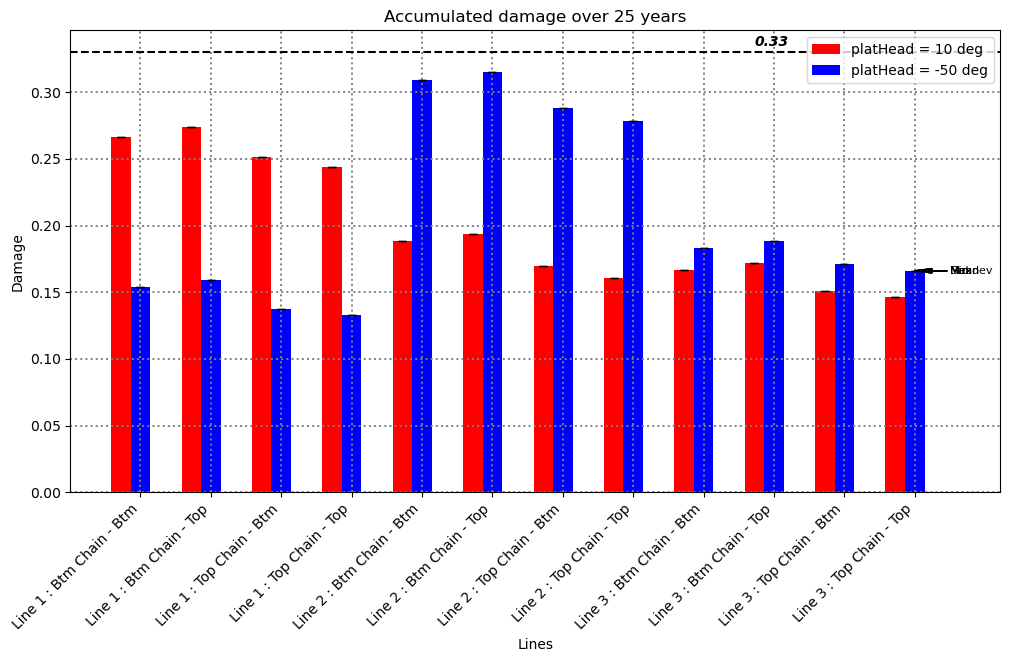

In [21]:

fig, ax = plt.subplots(1,1, figsize=(12, 6))


barWidth = 1/3/1.2

colorList = ['red', 'blue', 'green']



for typeIndex, key in enumerate(damCaseDict.keys()):

    damRenameDf = damCaseDict[key].copy()
    damRenameDf = damRenameDf.loc[LineMap.keys(), :]
    damRenameDf = damRenameDf.rename(index = LineMap)

    for barIndex, (ind, row) in enumerate(damRenameDf.iterrows()):
        if barIndex == 0:
            label = 'platHead = ' +  key.split('_')[1] + ' deg'
        else:
            label = ''

        ax.bar(barIndex - barWidth + typeIndex * barWidth, row['mean'], yerr = row['std'], capsize=barWidth*10, label = label, width = barWidth, color = colorList[typeIndex])
        ax.bar(barIndex - barWidth + typeIndex * barWidth, row['max'] - row['min'], bottom = row['min'], width = barWidth/1.7, color = 'grey', alpha = 0.8)


        if barIndex == len(damRenameDf)-1 and typeIndex == len(damCaseDict)-1:
        
            ax.annotate('Mean', xy=(barIndex - barWidth + typeIndex * barWidth,  row['mean']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['mean']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            ax.annotate('Std.dev', xy=(barIndex - barWidth + typeIndex * barWidth,  row['mean']+row['std']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['mean']+row['std']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            ax.annotate('Min', xy=(barIndex - barWidth + typeIndex * barWidth,  row['min']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['min']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            ax.annotate('Max', xy=(barIndex - barWidth + typeIndex * barWidth,  row['max']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['max']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')



# ax.set_xticks(range(len(damRenameDf.index)))



plt.title(f'Accumulated damage over 25 years')
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
# # plt.legend().remove()
plt.ylabel('Damage')
plt.xlabel('Lines')

plt.axhline(y =0.33, color='k', linestyle='--')
xLims = plt.xlim() 
ax.set_xlim(xLims[0], xLims[1] + 0.5)
ax.set_xticks(range(len(damRenameDf.index)))
ax.set_xticklabels(damRenameDf.index, rotation=45, ha='right')
ax.legend()

plt.text(xLims[1] -3, 0.335, '0.33', fontstyle='italic', color='k', weight='bold', )

### Simplified version of the above plot

In [9]:
damCaseDict.keys()

dict_keys(['C135_0', 'C135_10', 'C135_-50'])

Text(9.008333333333333, 0.335, '0.33')

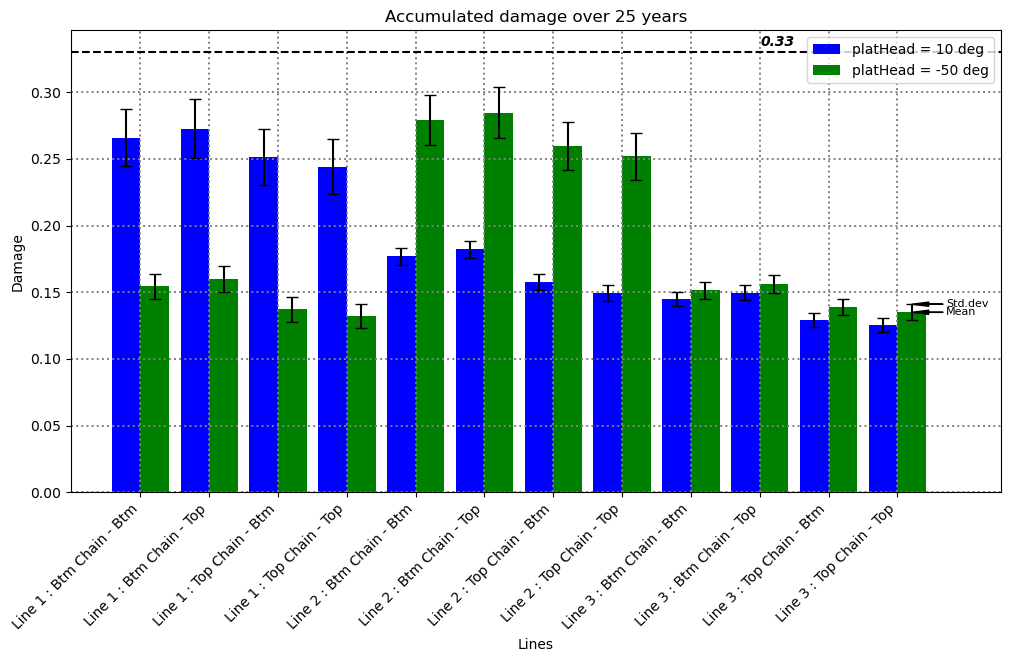

In [16]:

fig, ax = plt.subplots(1,1, figsize=(12, 6))


barWidth = 1/2/1.2

colorList = [ 'blue', 'green']


for typeIndex, key in enumerate(list(damCaseDict.keys())[1:]):

    damRenameDf = damCaseDict[key].copy()
    damRenameDf = damRenameDf.loc[LineMap.keys(), :]
    damRenameDf = damRenameDf.rename(index = LineMap)

    for barIndex, (ind, row) in enumerate(damRenameDf.iterrows()):
        if barIndex == 0:
            label = 'platHead = ' +  key.split('_')[1] + ' deg'
        else:
            label = ''

        ax.bar(barIndex - barWidth/2 + typeIndex * barWidth, row['mean'], yerr = row['std'], capsize=barWidth*10, label = label, width = barWidth, color = colorList[typeIndex])
        # ax.bar(barIndex - barWidth/2 + typeIndex * barWidth, row['max'] - row['min'], bottom = row['min'], width = barWidth/1.7, color = 'grey', alpha = 0.8)


        if barIndex == len(damRenameDf)-1 and typeIndex == len(damCaseDict)-2:
        
            ax.annotate('Mean', xy=(barIndex - barWidth/2 + typeIndex * barWidth,  row['mean']), xytext=(barIndex - barWidth/2 + typeIndex * barWidth + 0.5, row['mean']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            ax.annotate('Std.dev', xy=(barIndex - barWidth/2 + typeIndex * barWidth,  row['mean']+row['std']), xytext=(barIndex - barWidth/2 + typeIndex * barWidth + 0.5, row['mean']+row['std']), size=8,
                            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            # ax.annotate('Min', xy=(barIndex - barWidth + typeIndex * barWidth,  row['min']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['min']), size=8,
            #                 arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')

            # ax.annotate('Max', xy=(barIndex - barWidth + typeIndex * barWidth,  row['max']), xytext=(barIndex - barWidth + typeIndex * barWidth + 0.5, row['max']), size=8,
            #                 arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=3), ha='left', va='center')



# ax.set_xticks(range(len(damRenameDf.index)))



plt.title(f'Accumulated damage over 25 years')
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = ":")
# # plt.legend().remove()
plt.ylabel('Damage')
plt.xlabel('Lines')

plt.axhline(y =0.33, color='k', linestyle='--')
xLims = plt.xlim() 
ax.set_xlim(xLims[0], xLims[1] + 0.5)
ax.set_xticks(range(len(damRenameDf.index)))
ax.set_xticklabels(damRenameDf.index, rotation=45, ha='right')
ax.legend(loc = 'upper right')

plt.text(xLims[1] -3, 0.335, '0.33', fontstyle='italic', color='k', weight='bold', )

## Convergence checks

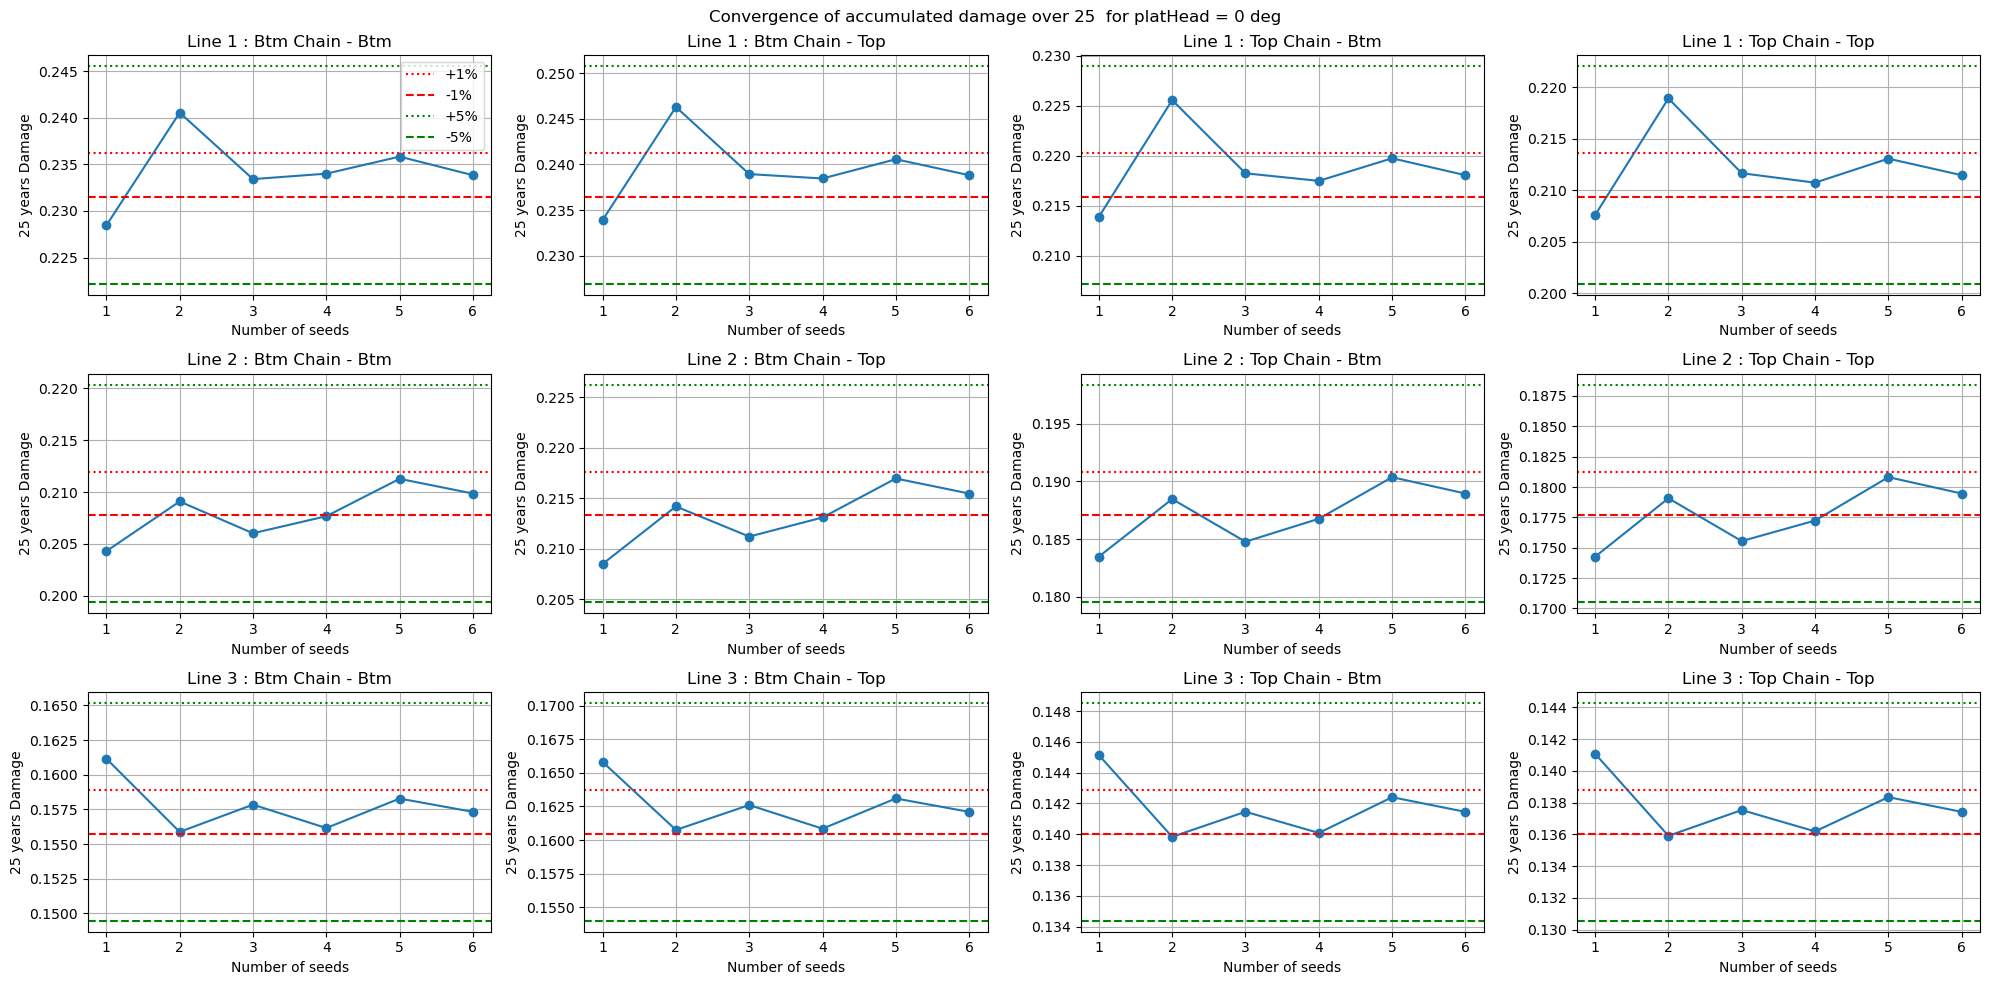

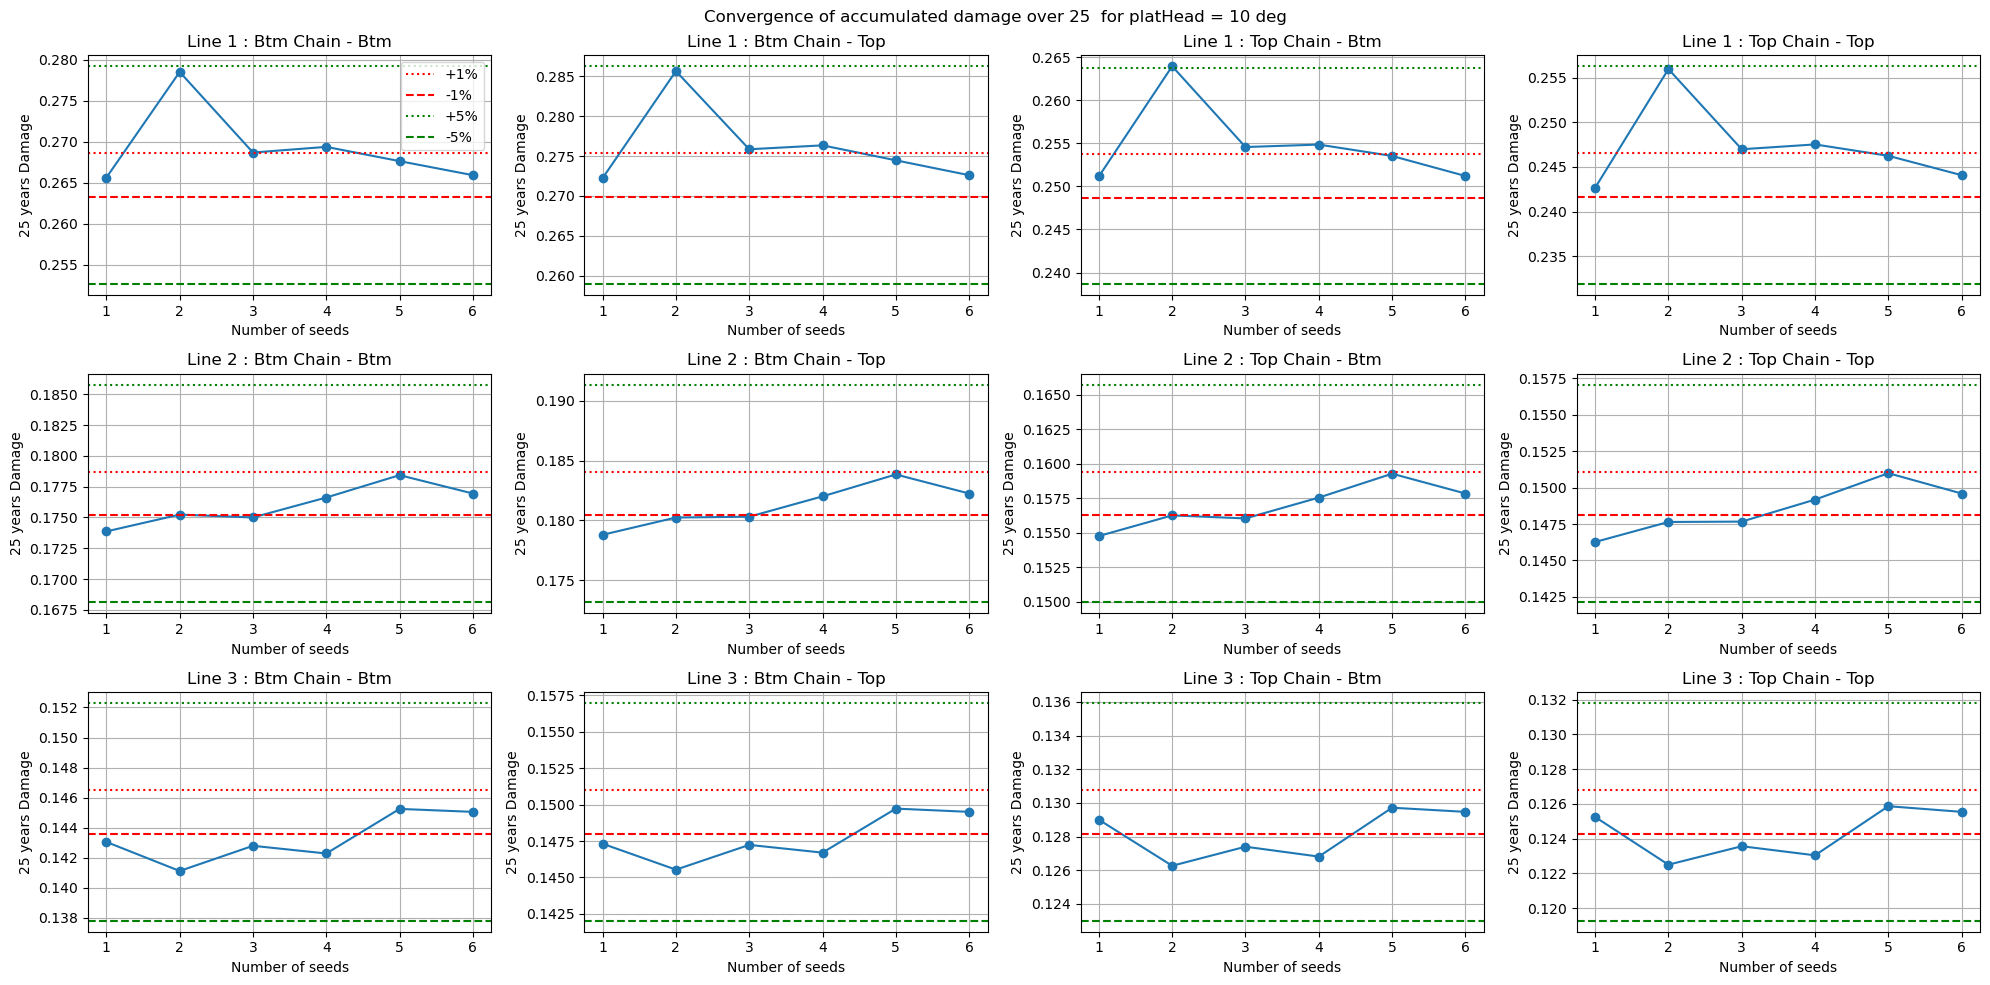

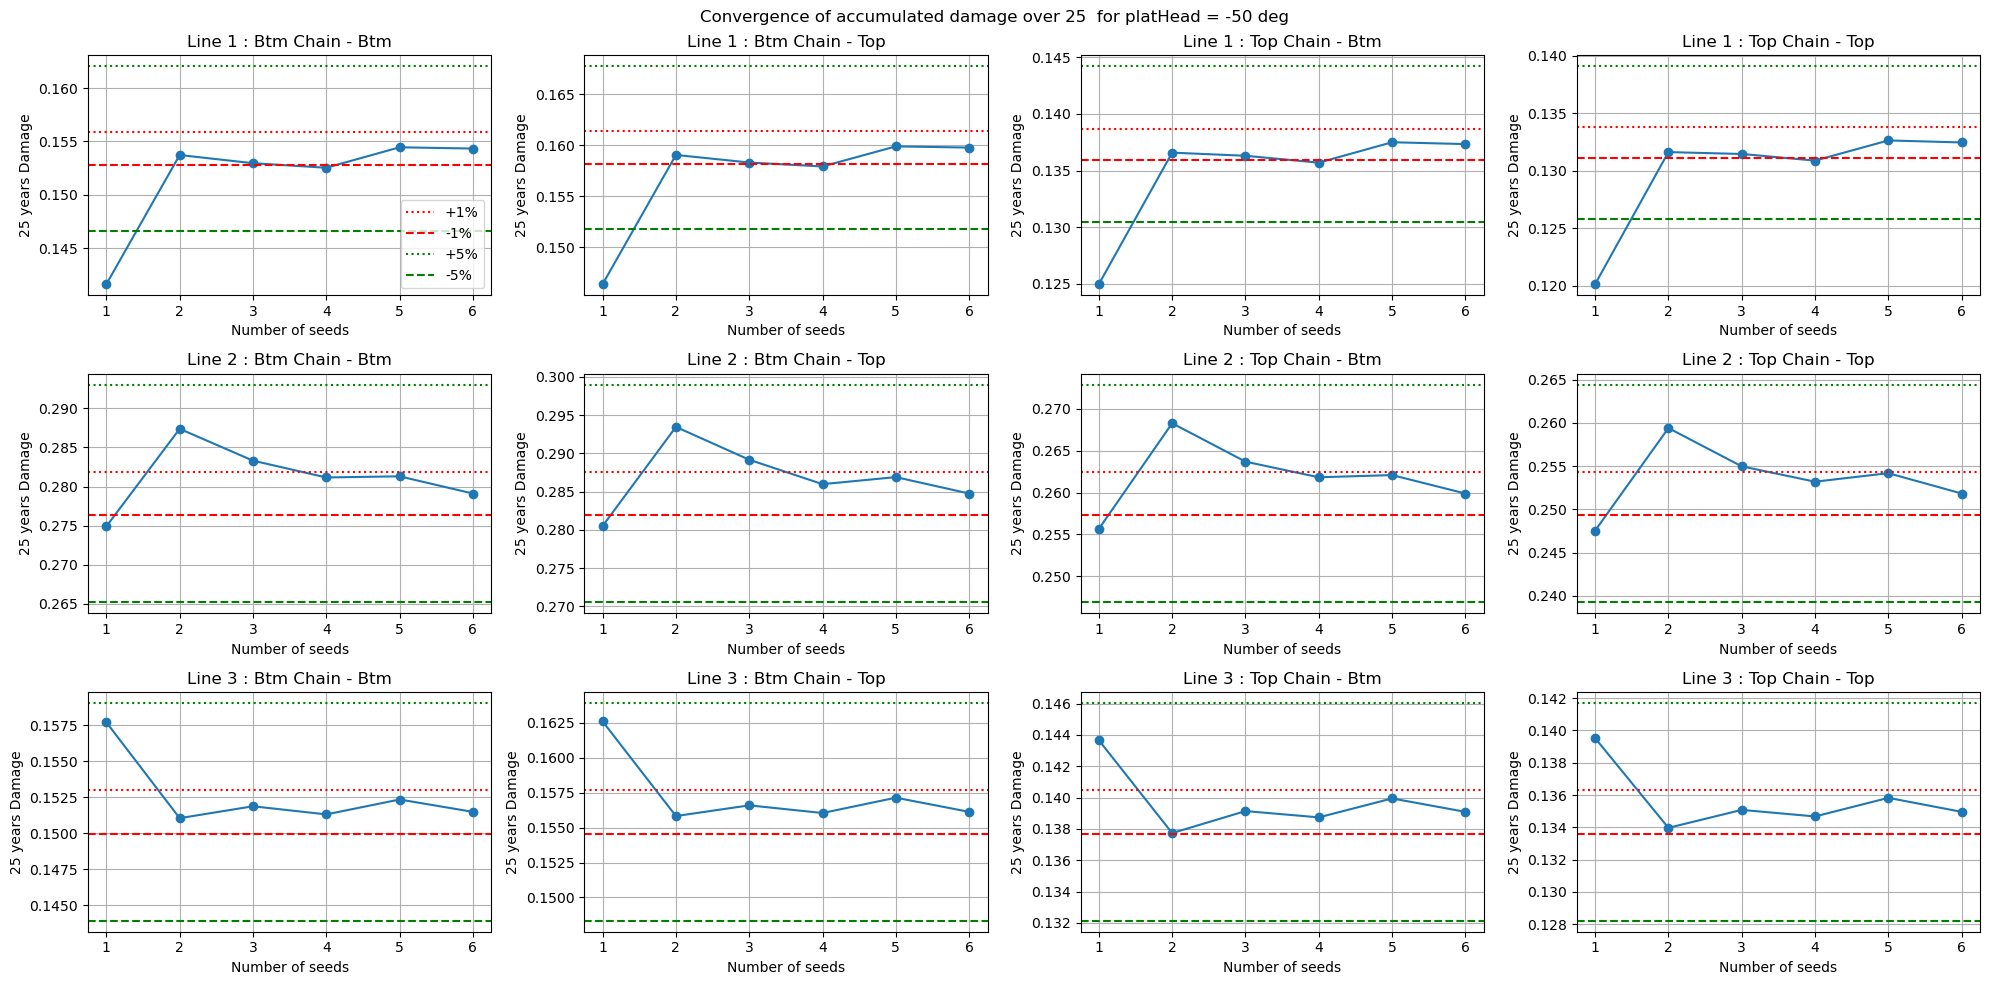

In [252]:
for key, df_path in lineDamageDict.items():

    df = pd.read_parquet(df_path)

    df = df.reset_index()
    df['bin'] = df['index'].str.extract(r'.*_(\d+)_.*').astype(int)
    df['seed'] = df['index'].str.extract(r'.*_S(\d+).*').astype(int)
    df.set_index('index', inplace=True)
    seedList = df['seed'].unique()


    convDict = {}

    for ind in range(1,len(seedList)+1):
        
        seeds = seedList[:ind]
        
        df_mean = df[df['seed'].isin(seeds)].groupby('bin').mean()

        damDict_mean = getDamDict(df_mean, fatBinDf)
        
        convDict[ind] = damDict_mean


    convDf = pd.DataFrame(convDict).T


    fig, axs = plt.subplots(3,4, figsize=(20, 10))

    fig.suptitle(f'Convergence of accumulated damage over 25  for {'platHead = ' +  key.split('_')[1] + ' deg'}')

    convDf = convDf[LineMap.keys()]

    for ind, (ax, col) in enumerate(zip(axs.flatten(), convDf.columns)):
        ax.plot(convDf.index, convDf[col], '-o')
        ax.axhline(y = convDf[col].values[-1]*1.01, color='r', linestyle=':', label = '+1%')
        ax.axhline(y = convDf[col].values[-1]*0.99, color='r', linestyle='--', label = '-1%')

        ax.axhline(y = convDf[col].values[-1]*1.05, color='g', linestyle=':', label = '+5%')
        ax.axhline(y = convDf[col].values[-1]*0.95, color='g', linestyle='--', label = '-5%')

        ax.set_title(LineMap[col])
        ax.grid()
        ax.set_xlabel('Number of seeds')
        ax.set_ylabel('25 years Damage')
        if ind == 0:
            ax.legend()
        ax.set_xticks(range(1, max(convDf.index)+1))
    plt.tight_layout()
